In [693]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import utils
import math

from dip.models.__init__ import get_net
from dip.utils.common_utils import get_noise
from dip.models.downsampler import Downsampler

env: CUDA_VISIBLE_DEVICES=0


In [694]:
#set up hyperparameters, net input/output sizes, and whether the problem is compressed sensing

LR = 1e-3 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 100 # number iterations
WD = 1e-4 # weight decay for l2-regularization
THRESH = 0.0
LOG_FREQ = 100 # frequency at which to display image during training

Z_NUM = 32 # input seed
NGF = 64 # number of filters per layer
ALEX_BATCH_SIZE = 1 # batch size of gradient step
nc = 1 #1 channel
WAVE_SIZE = 1024 #length of waveform
WAVE_PERIODS = 2

#if this is not a compressed sensing problem, we want A to be square 
compressed = False

if compressed:
    num_measurements = 64
else:
    num_measurements = WAVE_SIZE


In [695]:
CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


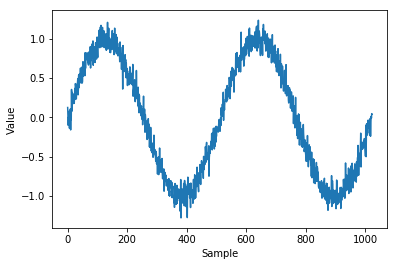

In [696]:
#Produces a sinusoid with optional additive gaussian noise distributed (mean, std)
def get_sinusoid(num_samples, num_periods, noisy=True, std=0.1, mean=0):
    
    Fs = num_samples
    x = np.arange(num_samples)
    
    y = np.sin(2*np.pi * num_periods * x / Fs)
    
    if noisy:
        y += (std * np.random.randn(num_samples)) + mean
    
    return y

y0 = get_sinusoid(num_samples = WAVE_SIZE, num_periods = WAVE_PERIODS, noisy=True)
                 
plt.plot(np.arange(1024), y0)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

In [697]:
#ugly solution for maintaining wave's original image stats for normalization/renormalization 
#normalization maps wave's range: [a,b] --> [-1,1], renormalization reverses this
def get_stats(x):
    a = np.min(x)
    b = np.max(x)
    mu = (a+b)/2.0
    sigma = (b-a)/2.0
    return [mu, sigma]

mu = get_stats(y0)[0]
sigma = get_stats(y0)[1]

def normalise(x):
    return (x-mu)/sigma

def renormalise(x):
    return x*sigma + mu

print(mu, sigma)

-0.023457943622680832 1.255613754287669


In [698]:
#convert array to tensor and normalise to [-1,1] for net's activation functions

y = torch.Tensor(y0)
y = normalise(y)
y = Variable(y.type(dtype))
print(y.shape)

torch.Size([1024])


In [699]:
#get the proper MSE loss based on the datatype
mse = torch.nn.MSELoss().type(dtype)

In [700]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=1024, nc=1, num_measurements=64):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size

        #Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        #Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size
        
        self.conv1 = nn.ConvTranspose1d(nz, ngf, 16, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm1d(ngf)
        #LAYER 1: input: (random) zϵR^(nzx1), output: x1ϵR^(2048x16) (channels x length) 
        
        self.conv2 = nn.ConvTranspose1d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(ngf)
        #LAYER 2: input: x1ϵR^(2048x16), output: x2ϵR^(1024x32) (channels x length) 
        
        self.conv3 = nn.ConvTranspose1d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm1d(ngf)
        #LAYER 3: input: x2ϵR^(1024x32), output: x3ϵR^(512x64) (channels x length) 
        
        self.conv4 = nn.ConvTranspose1d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm1d(ngf)
        #LAYER 4: input: x3ϵR^(512x64), output: x4ϵR^(256x128) (channels x length) 
        
        self.conv5 = nn.ConvTranspose1d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm1d(ngf)
        #LAYER 5: input: x4ϵR^(256x128), output: x5ϵR^(128x256) (channels x length) 
        
        self.conv6 = nn.ConvTranspose1d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm1d(ngf)
        #LAYER 6: input: x5ϵR^(128x256), output: x6ϵR^(64x512) (channels x length) 
        
        self.conv7 = nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False) #output is image
        #LAYER 7: input: x6ϵR^(64x512), output: (sinusoid) G(z,w)ϵR^(1x1024) (channels x length) 
        
        self.fc = nn.Linear(output_size*nc,num_measurements, bias=False) #output is A; measurement matrix
        # each entry should be drawn from a Gaussian (random noisy measurements)
        # don't compute gradient of self.fc! memory issues
   
    def forward(self, x):
        input_size = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.tanh(self.conv7(x))
       
        return x
   
    def measurements(self, x):
        # this gives the image - make it a single row vector of appropriate length
        y = self.forward(x).view(1,-1)
        y = y.cpu()
        
        #pass thru FC layer - returns A*image
        meas = self.fc(y)
        
        if CUDA:
            return meas.cuda()
        else:
            return meas

In [701]:
# get a DCGAN that outputs images of size WAVE_SIZE
net = DCGAN(Z_NUM,NGF,WAVE_SIZE,nc,num_measurements) # initialize network
net.fc.requires_grad = False

if CUDA: # move network to GPU if available
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")
    
# initialize fully-connected layer weights as our matrix A    
# if compressed, A_tensor: gaussian(0,1) entries in matrix of dim'n R^(num_meas x (wave_size x num_channels))
# else, A = identity
if compressed:
    net.fc.weight.data = (1/math.sqrt(1.0*num_measurements)) * torch.randn(num_measurements, WAVE_SIZE*nc)
else:
    net.fc.weight.data = torch.eye(num_measurements)

allparams = [x for x in net.parameters()] #specifies which to compute gradients of
allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive


# Define input seed z as Torch variable, normalize
z = Variable(torch.zeros(ALEX_BATCH_SIZE*Z_NUM).type(dtype).view(ALEX_BATCH_SIZE,Z_NUM,1))
z.data.normal_().type(dtype)

# Define optimizer
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

USING CUDA


In [702]:
print(z.shape)

torch.Size([1, 32, 1])


In [703]:
# Create measurements y, move to Torch variable
# torch.mm does matrix multiplication on a flattened row-major version of the image (R^(1)X(H*W*Ch)) and A^T (R^(H*W*Ch)X(measurements)) to produce a R^(measurements vector)
measurements = Variable(torch.mm(y.cpu().data.view(ALEX_BATCH_SIZE,-1),net.fc.weight.data.permute(1,0)),requires_grad=False) 

if CUDA: # move measurements to GPU if possible
    measurements = measurements.cuda()
    
print(measurements.shape)

torch.Size([1, 1024])


/home/sravula/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


99 tensor(0.0044, device='cuda:0')


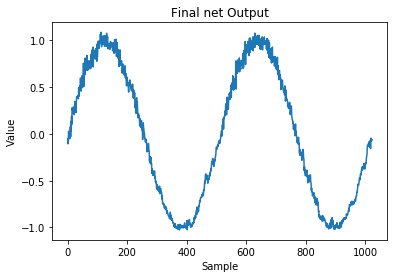

Output MSE:  0.00237
Noisy Signal MSE:  0.00997
Is final output better than noisy?:  True - Noisy MSE is  320.256  percent greater
Execution Time:  1.25 s


In [704]:
import time

# Create numpy logs to store images, MSE values (from ground truth) for each iteration
mse_log = np.zeros((NUM_ITER))#, nc))
wave_log = np.zeros((NUM_ITER, WAVE_SIZE))#, nc))

y0_denoised = get_sinusoid(num_samples = WAVE_SIZE, num_periods = WAVE_PERIODS, noisy=False)

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces wave (in form of data tensor) i.e. G(z,w)
    loss = mse(net.measurements(z),measurements) # calculate loss between AG(z,w) and Ay
         
    # DCGAN output is in [-1,1]. Renormalise to [0,1] before plotting
    wave = renormalise(out).data[0].cpu().numpy()[0,:] 

    wave_log[i] = wave # save image to image_log
    mse_log[i] = np.mean((y0_denoised - wave)**2)
    
    if i == NUM_ITER - 1:
        print(i,loss.data)
        
        plt.plot(np.arange(1024), wave)
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Final net Output")
        plt.show()
    
    loss.backward()
    optim.step()
    
#calculate MSE between output wave and non-noisy original; and between noisy and original
True_MSE = mse_log[NUM_ITER-1]
Noisy_MSE = np.mean((y0 - y0_denoised)**2)
print("Output MSE: ", round(True_MSE, 5))
print("Noisy Signal MSE: ", round(Noisy_MSE, 5))
print("Is final output better than noisy?: ", True_MSE < Noisy_MSE, "- Noisy MSE is ", round(100.0*(Noisy_MSE - True_MSE)/True_MSE, 3), " percent greater")

end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

Min Index: 64
Min MSE:   1.1079e-03
Last MSE: 2.3713e-03
Noisy MSE is  799.4695 percent greater than min network MSE


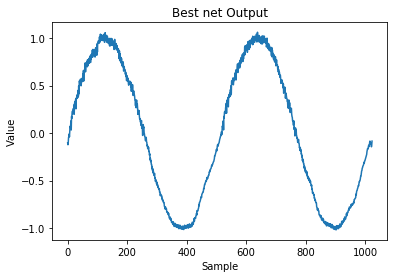

In [705]:
from decimal import Decimal 

# format value n (to 4 decimal pts) for easy visualization
def format_e(n, dec=4, is_hparam = False): 
    a = '%E' % n
    pre = a.split('E')[0].rstrip('0').rstrip('.')
    pre = str(round(float(pre), dec))
    if is_hparam == True:
        pre = str(int(float(pre))) # get rid of decimal
    return pre + 'e' + a.split('E')[1]
    
min_idx = np.argmin(mse_log) # find iteration with lowest loss
wave_best = wave_log[min_idx] # get corresponding image
min_mse = format_e(mse_log[min_idx]) # get corresponding mse
last_mse = format_e(mse_log[NUM_ITER-1]) # get mse of last iter'n

print('Min Index: ' + str(min_idx))
print('Min MSE:   ' + str(min_mse))
print('Last MSE: ' + str(last_mse))
min_diff = 100.0*(Noisy_MSE - mse_log[min_idx])/mse_log[min_idx]
print("Noisy MSE is ", round(min_diff, 4), "percent greater than min network MSE")

plt.plot(np.arange(1024), wave_best)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Best net Output")
plt.show()

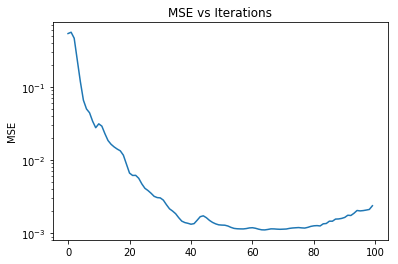

In [706]:
from matplotlib.axes import Axes

itern = np.arange(NUM_ITER) #iteration

#MSE graph
plt.figure()
plt.ylabel('MSE')
plt.title("MSE vs Iterations")
plt.semilogy(itern, mse_log)